## Predicting crop types in the Netherlands

Here we work with the Netherlands crop types dataset. 


### Exploratory data analysis

First let's get familiar with the dataset, find out nulls/outliers or discover patterns that could help us for prediction. 

In [270]:
#from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import psycopg2
import seaborn as sns
from sklearn.model_selection import train_test_split

from shapely.wkt import loads as wkt_loads
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import fiona
import geopandas as gp

%matplotlib inline 

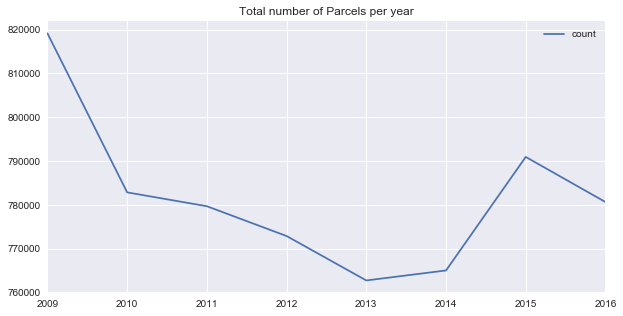

In [272]:

try:
    conn = psycopg2.connect("dbname='crops' user='postgres' host='localhost' port='5433'")
    cur = conn.cursor()
except:
    print "Unable to connect to the database"


cur.execute("""
SELECT  (
        SELECT COUNT(*)
        FROM   "2009"      ) AS count9,
        (
        SELECT COUNT(*)
        FROM   "2010"       ) AS count10,
        
        (
        SELECT COUNT(*)
        FROM   "2011"       ) AS count11,
        
        (
        SELECT COUNT(*)
        FROM   "2012"       ) AS count12,
        (
        SELECT COUNT(*)
        FROM   "2013"       ) AS count13,
        (
        SELECT COUNT(*)
        FROM   "2014"       ) AS count14,
        (
        SELECT COUNT(*)
        FROM   "2015"       ) AS count15,
        (
        SELECT COUNT(*)
        FROM   "2016"       ) AS count16

""")
rows = cur.fetchall()

rowCounts = pd.DataFrame(list(rows[0]), index=["2009","2010","2011","2012","2013","2014","2015","2016"],columns=["count"])
rowCounts.plot(title="Total number of Parcels per year", kind='line', figsize=(10,5))

Number of parcels follows a descending pattern from 2009 to 2013 with a second peak in 2015. I wonder if the nature of parcels in 2009 is the same as other years, or if anything else could explain the fall and rise.

I'll use the polygons in 2009 as the reference and compare parcels in subsequent years with polygons in this year. 

In [273]:
%%time 

refDf = gp.read_postgis('select global_geo_id, geom, centroid_x, centroid_y, gws_gewas as c2009 from "2009"', conn)


for i in range(2010,2017):
    if i <2015:
        q = 'select gws_gewas as c'+str(i)+', global_geo_id from "'+str(i)+'"'
    else: #table name for 2015 and 2016 is different 
        q = 'select gws_gewas as c'+str(i)+', global_geo_id from "bf_'+str(i)+'"'
    
    tmp_df =  pd.read_sql_query(q, conn)
    refDf = refDf.merge(tmp_df,how="left")


CPU times: user 35.5 s, sys: 14.3 s, total: 49.7 s
Wall time: 1min 17s


number of potatos in different years 
visualization of potato fields and soil type 


In [274]:
refDf.head(1)

,global_geo_id,geom,centroid_x,centroid_y,c2009,c2010,c2011,c2012,c2013,c2014,c2015,c2016
0,809478,(POLYGON ((233366.9770000018 485300.7219999991...,233351.867091,485288.226863,"Grasland, blijvend","Grasland, blijvend",NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
for i in range(2010,2017):
    print 'Missing parcels in {}: '.format(i), refDf['c'+str(i)].isnull().sum()
    
    
df_noNA = refDf.dropna()
df_noNA = df_noNA.sample(frac=1)
print "No NA dataset size: ", len(df_noNA)


Missing parcels in 2010:  130436
Missing parcels in 2011:  166271
Missing parcels in 2012:  193027
Missing parcels in 2013:  219926
Missing parcels in 2014:  240144
Missing parcels in 2015:  258764
Missing parcels in 2016:  269943
No NA dataset size:  464060


let's have a look at the crop types:

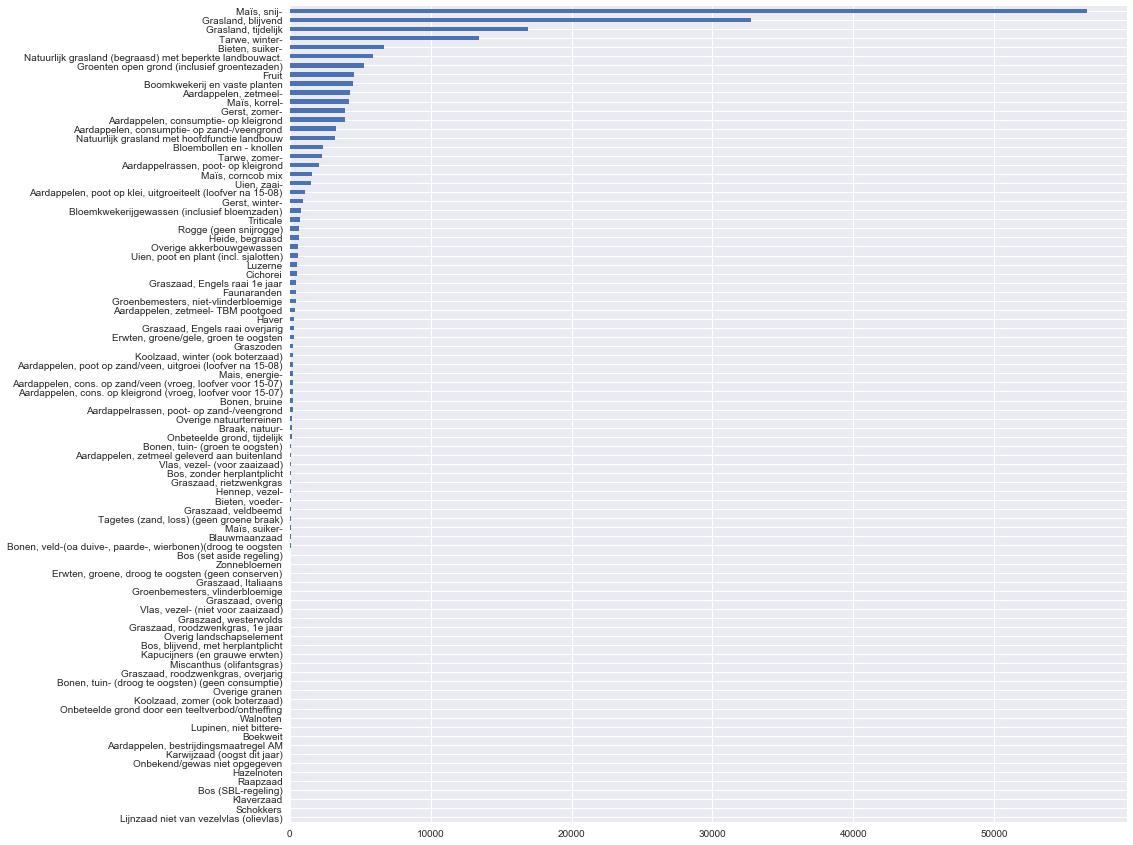

In [284]:
df_noNA.c2010.value_counts().sort_values().plot(kind='barh',figsize=(15, 15))


It seems a large number of parcels are not intentionally farmed, like "Grasland". I went through unique values of crops in each year (in PostGIS) and came up with a list of such crop types:

In [285]:

useless_parcels = ["Braak, natuur-",
                   "Onbeteelde grond, tijdelijk",
                   "Onbekend/gewas niet opgegeven",
                   "Tagetes (zand, loss) (geen groene braak)",
                   "Bos (SBL-regeling)",
                   "Natuurlijk grasland met hoofdfunctie landbouw",
                   "Braak met bos (SBL-regeling na 28 juni 1995)",
                   "Natuurlijk grasland (begraasd) met beperkte landbouwact.",
                   "Grasland, tijdelijk",
                   "Bos (set aside regeling)",
                   "Bos, blijvend, met herplantplicht",
                   "Dummycode voor dummypercelen",
                   "Overige natuurterreinen",
                   "Faunaranden",
                   "Bos, zonder herplantplicht",
                   "Onbeteelde grond door een teeltverbod/ontheffing",
                   "Woudbomen met korte omlooptijd",
                   "Faunaranden, grasland",
                   "Definitief aan de landbouw onttrokken cultuurgrond",
                   "Faunaranden, bouwland",
                   "Bos- en haagplanten, open grond,",
                   "Woudbomen met korte omlooptijd (excl. Wilgenhakhout)",
                   "Laanbomen/parkbomen, onderstammen, open grond,",
                   "Grasland, natuurlijk. Hoofdfunctie landbouw.",
                   "Buxus, open grond,",
                   "Vruchtbomen, onderstammen, open grond,",
                   "Rand, grenzend aan bouwland, hoofdzakelijk bestaand uit een",
                   "Bos zonder herplantplicht",
                   "Sloot, grenzend aan beheerde akkerrand",
                   "Natuurterreinen (incl. heide)",
                   "Vruchtbomen, overig, open grond,",
                   "Rozenstruiken (incl, zaailingen en onderstammen), open grond",
                   "Laanbomen/parkbomen, onderstammen, pot- en containerveld,",
                   "Trek- en besheesters, open grond,",
                   "Vaste planten, open grond,"
                   "Laanbomen/parkbomen, opzetters, open grond,",
                   "Rand, grenzend aan blijvend grasland of een blijvende teelt,",
                   "Rozenstruiken (incl, zaailingen en onderstammen), pot- en co",
                   "Sierconiferen, pot- en containerveld,",
                   "Buxus, pot- en containerveld,",
                   "Laanbomen/parkbomen, spillen, open grond,",
                   "Laanbomen/parkbomen, opzetters, pot- en containerveld,"
                   "Wijndruiven",
                   "Rand, grenzend aan bouwland, hoofdzakelijk bestaand uit blij",
                   "Grasland, natuurlijk. Hoofdfunctie natuur.",
                   "Onbeteelde grond vanwege een teeltverbod/ontheffing",
                   "Bos- en haagplanten, pot- en containerveld,"
                   "Rand, grenzend aan blijvend grasland of een blijvende teelt, hoofdzakelijk bestaand uit een ander gewas dan gras",
                   "Overige niet genoemde groenten, zaden en opkweekmateriaal",
                   "Grasland, natuurlijk. Areaal met een natuurbeheertype dat overwegend voor landbouwactiviteiten-GLB wordt gebruikt",
                   "Overige niet genoemde groenten, productie",
                   "Rand, grenzend aan bouwland, hoofdzakelijk bestaand uit een ander gewas dan gras",
                   "Overige niet genoemde bladgewassen, productie",
                   "Grasland, blijvend"
                   
]

for i in range(2009,2017):
    print 'Useless parcels in year {}: '.format(i), refDf['c'+str(i)].isin(useless_parcels).sum()
    
    

Useless parcels in year 2009:  538323
Useless parcels in year 2010:  464918
Useless parcels in year 2011:  445048
Useless parcels in year 2012:  410778
Useless parcels in year 2013:  390097
Useless parcels in year 2014:  380284
Useless parcels in year 2015:  391110
Useless parcels in year 2016:  385820


Now that's a large number for each year! I'll take out a parcel from our study if in every year it's said to have a useless crop type.

In [286]:
useless_parcels_in_all_years = refDf[refDf['c2009'].isin(useless_parcels) & \
             refDf['c2010'].isin(useless_parcels) &\
             refDf['c2011'].isin(useless_parcels) &\
             refDf['c2012'].isin(useless_parcels) &\
             refDf['c2013'].isin(useless_parcels) &\
             refDf['c2014'].isin(useless_parcels) &\
             refDf['c2015'].isin(useless_parcels) &\
             refDf['c2016'].isin(useless_parcels) ]
print "Number of parcels that aren't used across all the years: {}.\
\nThis is {}% of all parcels in 2009 and {}% of our no-null dataset."\
.format( len(useless_parcels_in_all_years), \
        len(useless_parcels_in_all_years)*100/len(refDf),\
        len(useless_parcels_in_all_years)*100/len(df_noNA)
       )




Number of parcels that aren't used across all the years: 270222.
This is 32% of all parcels in 2009 and 139% of our no-null dataset.


In [288]:

cleaned_df = refDf[~(refDf['c2009'].isin(useless_parcels) & \
             refDf['c2010'].isin(useless_parcels) &\
             refDf['c2011'].isin(useless_parcels) &\
             refDf['c2012'].isin(useless_parcels) &\
             refDf['c2013'].isin(useless_parcels) &\
             refDf['c2014'].isin(useless_parcels) &\
             refDf['c2015'].isin(useless_parcels) &\
             refDf['c2016'].isin(useless_parcels)) ]


df_noNA = cleaned_df.dropna()
df_noNA = df_noNA.sample(frac=1)
print "Dataset size after removing Nils and unused parcels: ", len(df_noNA)


Dataset size after removing Nils and unused parcels:  193838


Let's look at the distribution of potatot fields:

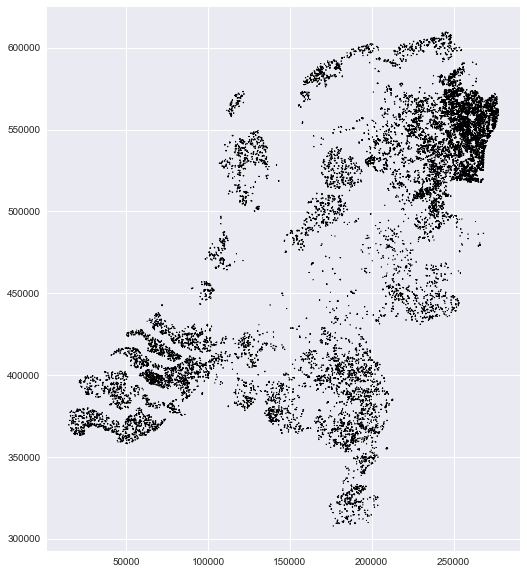

In [45]:
df_noNA[df_noNA['c2009'].str.contains("Aardappelen")].geom.plot(figsize=(15,10))

Apparently potatos are not grown in all regions, it could have to do with soil types for example.

## Soil analysis
ToDo

In [55]:
# soilDf = pd.read_sql_query('select * from "soil_map"', conn)
# soilDf = gp.read_postgis('select geom, gronds, omschrijvi from "soil_map"', conn)
# soilDf.head()

,geom,gronds,omschrijvi
0,"(POLYGON ((195307 593360, 195283 593362, 19524...",99,Water
1,"(POLYGON ((254999 593380, 255004 593309, 25499...",30,Lichte zavel
2,"(POLYGON ((228985 593442, 229068 593301, 22910...",40,Zware zavel
3,"(POLYGON ((202285 593207, 202206 593229, 20208...",30,Lichte zavel
4,"(POLYGON ((240259 593177, 240180 593200, 24011...",30,Lichte zavel


In [24]:
len(soilDf)

17340

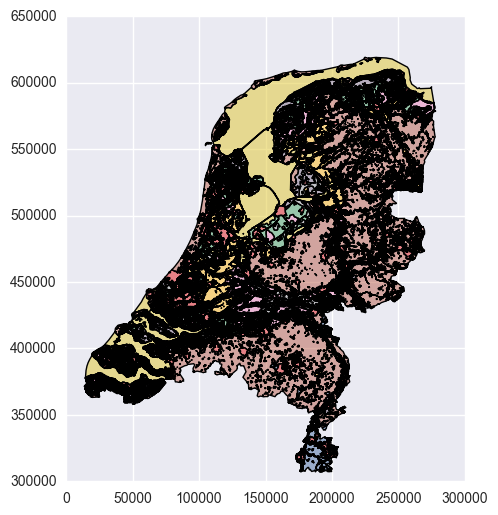

In [25]:
soilDf.plot(figsize=(10, 6),column='omschrijvi')

## Model Training

We have to convert our categorical crop type values to numerical values. For now we're only interested in potatos, so we'll treat our problem as a binary classification problem: if crop type is potato we set value to 1 and otherwise to 0.




In [289]:
# change categorical variables for model training
# for now we're interested in potatos, so if crop type contains the word Aardappelen we'll set it to 1, otherwise to 0
ml_df = df_noNA.copy()
ml_df.loc[:,"c2009":] = ml_df.ix[:,"c2009":].applymap(lambda x: 1 if "aardappelen" in x.lower() else 0 )
ml_df.head(5)

,global_geo_id,geom,centroid_x,centroid_y,c2009,c2010,c2011,c2012,c2013,c2014,c2015,c2016
677371,617782,(POLYGON ((145067.1149999984 390285.1790000014...,145093.830917,390259.018468,0,0,1,0,0,0,0,0
344217,215206,(POLYGON ((234861.3420000002 542914.3319999985...,235019.836406,542726.404829,1,0,0,0,0,0,0,0
504338,439326,(POLYGON ((184972.7729999982 385258.1840000004...,184997.419459,385322.071801,0,0,0,0,0,0,0,0
503703,438684,"(POLYGON ((218877.131000001 602658.7780000009,...",218960.400181,602626.288473,0,0,0,0,0,0,0,0
415991,343845,"(POLYGON ((204746.1750000007 598281.307, 20474...",204676.107907,598298.163335,0,0,0,0,0,0,0,0


Across all the years, how many times have they grown potato on each field?

In [294]:
sr = ml_df.ix[:,"c2009":].sum(axis=1)
print sr.groupby(sr).size()

0    126588
1     29804
2     24684
3      7485
4      4937
5       310
6        25
7         2
8         3
dtype: int64


In [76]:
ml_df.insert(1,"potato_history",False)

A better look at the distribution across the years:

In [122]:
sr = ml_df.groupby(['c2009', 'c2010',"c2011","c2012","c2013","c2014","c2015","c2016"]).count()["global_geo_id"]
sr_r = sr.copy()
sr_r.sort_values(axis=0,ascending=False,inplace=True)
sr_r
# sr_r.index
# sr.index.names

c2009  c2010  c2011  c2012  c2013  c2014  c2015  c2016
0      0      0      0      0      0      0      0        126588
                                   1      0      0          5975
                            1      0      0      0          4666
                            0      0      1      0          3957
                                          0      1          3665
                     1      0      0      0      0          3526
              1      0      0      0      0      0          3066
                                   1      0      0          2868
                                   0      1      0          2658
       1      0      0      0      0      0      0          2624
       0      0      1      0      0      0      1          2511
       1      0      0      0      1      0      0          2498
1      0      0      0      0      0      0      0          2325
0      0      0      1      0      0      1      0          2045
                     0      1      

I have a hypothesis that not all areas are suitable for growing potatos (as we saw on the map earlier).
It could also be that the field is used to grow crops that take years to yield like christmas trees or grapes. 

Given this, I'm adding a feature to each field which records number of times potatos was grown on that field. 

In [295]:
#exclude 2016

ml_df.insert(1,"potato_history",False)
ml_df.potato_history = ml_df.ix[:,"c2009":"c2016"].sum(axis=1)


Percentage of fields bearing potatos for each year:

In [298]:
ml_df.ix[:,"c2009":].mean()*100

c2009    6.843859
c2010    7.143594
c2011    7.416502
c2012    7.731714
c2013    8.484920
c2014    8.650007
c2015    8.406504
c2016    8.836245
dtype: float64

We'll now create our training and test sets based on the 60% split.

In [299]:
traindf = ml_df.iloc[0:int(0.6*len(ml_df))]
testdf = ml_df.iloc[int(0.6*len(ml_df)):]
len(traindf)

116302

Here we're dealing with time series prediction, basically given crop types for the past **n** years, what is the prediction for next year. For this purpose, we'll have to re-structure our training set so that for every parcel we have one row pertaining to (crops in years n, crop in year n+1). 


We can pass various parameters to the following function; namely: look back window (n), and common features that will be replicated for all the new rows.

In [301]:
# num_common_features: Number of features except for global_geo_id and crop types per year
# todo: derive number of common features automatically


def create_dataset(df,look_back,num_common_features):
    dataX, dataY = [], []

    for index, row  in df.iterrows():
        #print row

        for i in range(1+num_common_features,len(df.columns)-look_back):
            commons = row[1:num_common_features+1]
            a = row[i:(i+look_back)]
            #print "a: ", np.append(commons, a)
            
            
            dataX.append(np.append(commons, a))
            dataY.append(row[i + look_back])
            #print (dataX),"\n"
            
            
        
        
    return np.array(dataX), np.array(dataY)



In [310]:
%%time

X, y = create_dataset(traindf.drop(["centroid_x","centroid_y","geom"], axis=1),4,1) #use 2016 reserved for measuing prediction accuracy   


CPU times: user 1min 31s, sys: 1.38 s, total: 1min 32s
Wall time: 1min 36s


In [313]:
for i in range (200,210):
    print (X[i], y[i])


(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)
(array([0, 0, 0, 0, 0]), 0)


Ratio of Potato fields in the prediction variable y:

In [314]:
y.mean()

0.086000240752523605

Now we'll split our time series prediction dataset into training and validation sets. 
We'll be using a random forest classifer for our binary classification problem.
I'll put everything in a function for convenience of trying different methods in future.


Just a note that it may sound a bit of data leaking to know the potato history of the field for test set, but it's also the information that will be available at the time of prediction.

In [316]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def train_validate_predict(X1,y1, X2,y2):
    

    X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.33, random_state=19,stratify=y)

    clf = RandomForestClassifier(n_estimators=100,class_weight={1: 0.8, 0: 0.2}) #set class weight for potatos 
    clf.fit(X_train,y_train)

    print "Results on validation set:\n"
    print(classification_report(y_valid, clf.predict(X_valid)))
    
    print "And results on test set:\n"
    print(classification_report(y2, clf.predict(X2)))

In [315]:
Xtest, ytest = create_dataset(testdf.drop(["geom","centroid_x","centroid_y"], axis=1),4,1) #use 2016 reserved for measuing prediction accuracy   


In [317]:
train_validate_predict(X,y,Xtest,ytest)

Results on validation set:

             precision    recall  f1-score   support

          0       1.00      0.90      0.94    140316
          1       0.47      0.97      0.63     13203

avg / total       0.95      0.90      0.92    153519

And results on test set:

             precision    recall  f1-score   support

          0       1.00      0.90      0.94    283515
          1       0.47      0.97      0.63     26629

avg / total       0.95      0.90      0.92    310144



Now let's try by including centorid of each parcel as a feature

In [318]:
X, y = create_dataset(traindf.drop(["geom"], axis=1),4,3) #use 2016 reserved for measuing prediction accuracy   
Xtest, ytest = create_dataset(testdf.drop(["geom"], axis=1),4,3) #use 2016 reserved for measuing prediction accuracy   
train_validate_predict(X,y,Xtest,ytest)

Results on validation set:

             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96    140316
        1.0       0.58      0.60      0.59     13203

avg / total       0.93      0.93      0.93    153519

And results on test set:

             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97    283515
        1.0       0.67      0.67      0.67     26629

avg / total       0.94      0.94      0.94    310144



What if we only trained the model on potato parcels, i.e. those who have had potato as crop once in past years. The default prediction for other parcels will be 0 (not potato).

In [320]:
only_potatos_df = ml_df[ml_df.potato_history > 0]
traindf = only_potatos_df.iloc[0:int(0.6*len(only_potatos_ml))]
testdf = only_potatos_df.iloc[int(0.6*len(only_potatos_ml)):]
len(traindf)


38151

In [321]:
X, y = create_dataset(traindf.drop(["centroid_x","centroid_y","geom"], axis=1),4,1) #use 2016 reserved for measuing prediction accuracy   
Xtest, ytest = create_dataset(testdf.drop(["geom","centroid_x","centroid_y"], axis=1),4,1) #use 2016 reserved for measuing prediction accuracy   
train_validate_predict(X,y,Xtest,ytest)

Results on validation set:

             precision    recall  f1-score   support

          0       0.99      0.64      0.77     37908
          1       0.47      0.98      0.63     12452

avg / total       0.86      0.72      0.74     50360

And results on test set:

             precision    recall  f1-score   support

          0       0.99      0.64      0.77     87492
          1       0.47      0.98      0.63     28904

avg / total       0.86      0.72      0.74    116396



There's a caveat here, our test set actually contains only those parcels that have had a potato history, we need to run the model on all the parcels including those without a potato history:

In [354]:
predictions = ml_df.copy()
predictions.ix[predictions[predictions.potato_history ==0].index,"pred"] = 0 

potato_indeces = predictions[predictions.potato_history > 0].index
predictions.ix[potato_indeces,"pred"] = clf.predict(predictions.ix[potato_indeces,["potato_history","c2012","c2013","c2014","c2015"]])





In [356]:

excl_training_df = predictions[predictions.index.map(lambda x: x not in traindf.index)]
print len(excl_training_df[excl_training_df.potato_history ==0])


126588


In [357]:
print classification_report(excl_training_df.c2016, excl_training_df.pred)

             precision    recall  f1-score   support

          0       1.00      0.96      0.98    148278
          1       0.55      0.97      0.70      7409

avg / total       0.98      0.96      0.97    155687

